# GAMALIEL MARINES A01708746
-----

### BIG DATA PROJECT

# Prepare the ambience

## Install pyspark

In [ ]:
!pip install pyspark

## Different approach to avoid version conflicts

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

## Connect with google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Advanced AI/reto big data/chest_xray"

!ls

/content/drive/MyDrive/Advanced AI/reto big data/chest_xray
test  train


## Load the dataset and partitioning of the data
----
1. Training
2. Test

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name
import os
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema



train_dir = os.path.join('/content/drive/MyDrive/Advanced AI/reto big data/chest_xray/train')
test_dir = os.path.join('/content/drive/MyDrive/Advanced AI/reto big data/chest_xray/test')

# Load images recursively from subdirectories (NORMAL, PNEUMONIA)
train_df = spark.read.format("binaryFile") \
    .option("recursiveFileLookup", "true") \
    .option("pathGlobFilter", "*.jpeg") \
    .load(train_dir)

test_df = spark.read.format("binaryFile") \
    .option("recursiveFileLookup", "true") \
    .option("pathGlobFilter", "*.jpeg") \
    .load(test_dir)

# Show schema of the loaded images
train_df.printSchema()

# Show first few rows
train_df.show(5)


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/content/dri...|2017-12-31 02:29:09|2414342|[FF D8 FF E0 00 1...|
|file:/content/dri...|2017-12-31 02:30:38|2333158|[FF D8 FF E0 00 1...|
|file:/content/dri...|2017-12-31 02:30:25|2296542|[FF D8 FF E0 00 1...|
|file:/content/dri...|2017-12-31 02:32:55|2289236|[FF D8 FF E0 00 1...|
|file:/content/dri...|2017-12-31 02:28:47|2272982|[FF D8 FF E0 00 1...|
+--------------------+-------------------+-------+--------------------+
only showing top 5 rows



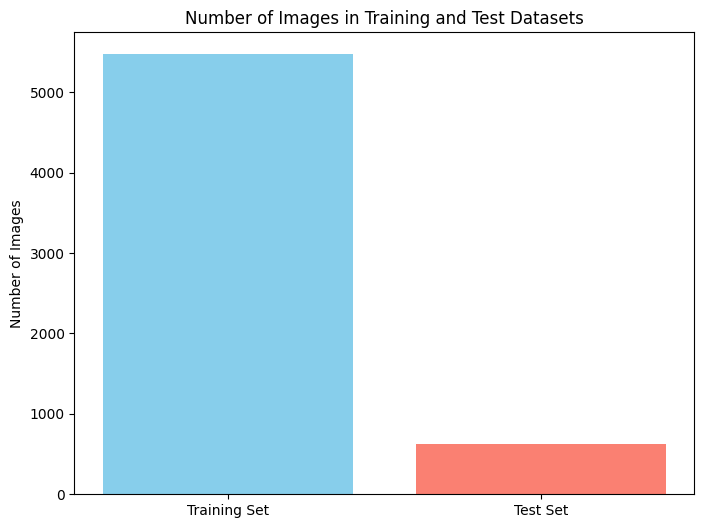

In [ ]:
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt

# Assuming you already have SparkSession created as `spark`
# and have loaded train_df and test_df

# Count the number of images in the training and test datasets
train_count = train_df.count()
test_count = test_df.count()

# Plot the counts
labels = ['Training Set', 'Test Set']
counts = [train_count, test_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.ylabel('Number of Images')
plt.title('Number of Images in Training and Test Datasets')
plt.show()


In [ ]:
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt

# Sample 1000 images for the new test set and 2000 for the validation set from train_df
test_from_train_df = train_df.sample(fraction=1000/train_df.count(), seed=42)
validation_from_train_df = train_df.sample(fraction=2000/train_df.count(), seed=43)

# Filter out these sampled images from the original training set to avoid duplication
train_remaining_df = train_df.subtract(test_from_train_df).subtract(validation_from_train_df)

# Combine original test set with new samples from the training set
new_test_df = test_df.union(test_from_train_df)
validation_df = validation_from_train_df


In [ ]:
train_count = train_remaining_df.count()
test_count = new_test_df.count()
validation_count = validation_df.count()

# Verify the counts of each subset
print(f"New training set size: {train_count}")
print(f"New test set size: {test_count}")
print(f"Validation set size: {validation_count}")

New training set size: 2802
New test set size: 1619
Validation set size: 2002


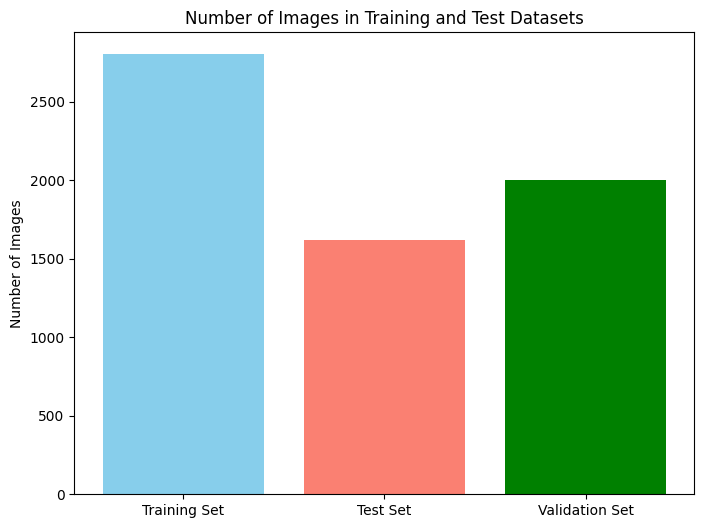

In [ ]:
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt


# Plot the counts
labels = ['Training Set', 'Test Set', 'Validation Set']
counts = [train_count, test_count, validation_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'green'])
plt.ylabel('Number of Images')
plt.title('Number of Images in Training and Test Datasets')
plt.show()


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, ArrayType, FloatType
from PIL import Image
import io
import numpy as np

# Function to decode image and convert to feature vector
def decode_image(content):
    img = Image.open(io.BytesIO(content))  # Open image from binary content
    img = img.resize((150, 150))  # Resize image to (150, 150)
    img_array = np.array(img).astype(np.float32).flatten() / 255.0  # Normalize pixel values and flatten
    return img_array.tolist()  # Return as a list for Spark compatibility

# Register UDF to decode images
decode_image_udf = udf(decode_image, ArrayType(FloatType()))

# Apply the UDF to the content column to create features
train_df = train_df.withColumn("features", decode_image_udf(train_df['content']))
test_df = test_df.withColumn("features", decode_image_udf(test_df['content']))

# UDF to extract label based on file path
def get_label(path):
    if 'NORMAL' in path:
        return 0
    elif 'PNEUMONIA' in path:
        return 1
    return -1

# Register UDF for labels
label_udf = udf(get_label, IntegerType())

# Add label column based on the path
train_df = train_df.withColumn('label', label_udf(train_df['path']))
test_df = test_df.withColumn('label', label_udf(test_df['path']))

# Show the rows to verify that both features and labels are correctly added
train_df.select("path", "label", "features").show(5)


+--------------------+-----+--------------------+
|                path|label|            features|
+--------------------+-----+--------------------+
|file:/content/dri...|    0|[0.039215688, 0.0...|
|file:/content/dri...|    0|[0.039215688, 0.0...|
|file:/content/dri...|    0|[0.023529412, 0.0...|
|file:/content/dri...|    0|[0.015686275, 0.0...|
|file:/content/dri...|    0|[0.0, 0.0, 0.0, 0...|
+--------------------+-----+--------------------+
only showing top 5 rows



<ipython-input-11-1bdf118c9f7f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='count', data=class_counts_pd, palette='rocket')


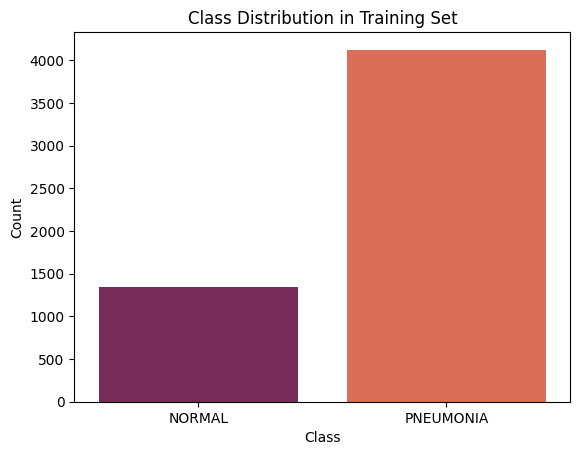

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of images per label in the Spark DataFrame
class_counts = train_df.groupBy("label").count()

# Convert the result to a Pandas DataFrame
class_counts_pd = class_counts.toPandas()
class_counts_pd['class'] = class_counts_pd['label'].map({0: 'NORMAL', 1: 'PNEUMONIA'})

# Plot the distribution
sns.barplot(x='class', y='count', data=class_counts_pd, palette='rocket')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


<ipython-input-12-7882cdbd5731>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='count', data=class_counts_pd, palette='rocket')


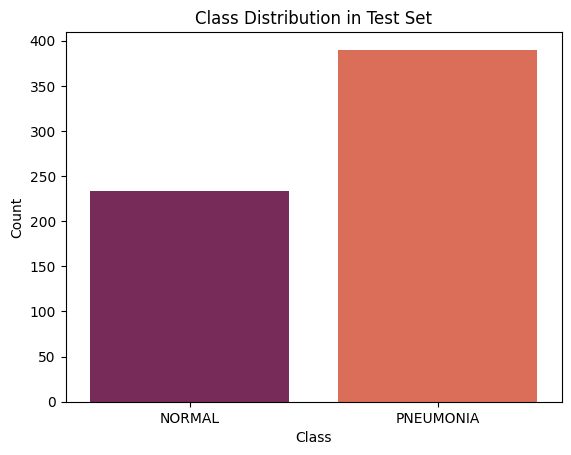

In [ ]:
# Count the number of images per label in the Spark DataFrame
class_counts = test_df.groupBy("label").count()

# Convert the result to a Pandas DataFrame
class_counts_pd = class_counts.toPandas()
class_counts_pd['class'] = class_counts_pd['label'].map({0: 'NORMAL', 1: 'PNEUMONIA'})

# Plot the distribution
sns.barplot(x='class', y='count', data=class_counts_pd, palette='rocket')
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


Sample images - NORMAL


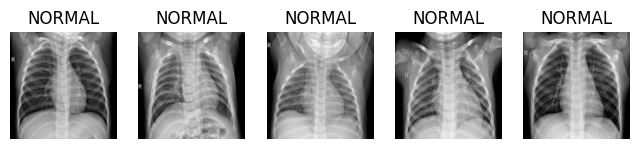

Sample images - PNEUMONIA


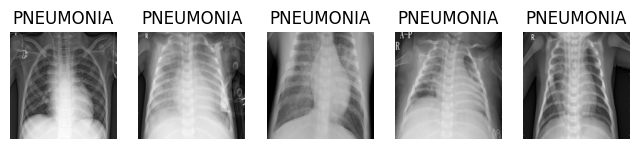

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualización de algunas muestras de imágenes
def plot_sample_images(df, label, n=5):
    sample_paths = df.filter(df.label == label).select("path").collect()
    sample_paths = random.sample(sample_paths, n)  # Select n random images
    fig, axes = plt.subplots(1, n, figsize=(8, 8))
    for i, row in enumerate(sample_paths):
        img_path = row['path'].replace("file:", "")  # Remove "file:" prefix
        img = Image.open(img_path).resize((150, 150))
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title("PNEUMONIA" if label == 1 else "NORMAL")
    plt.show()

# Visualizar imágenes de ambas clases en el set de entrenamiento
print("Sample images - NORMAL")
plot_sample_images(train_df, label=0)
print("Sample images - PNEUMONIA")
plot_sample_images(train_df, label=1)





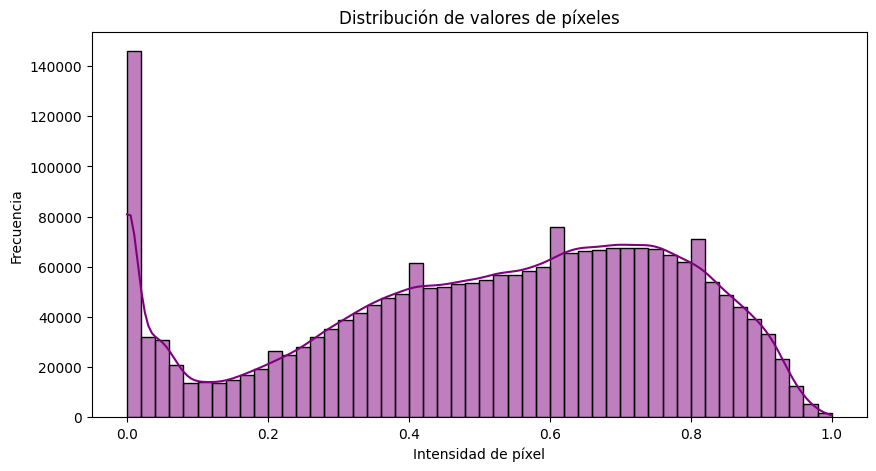

In [ ]:
# 2. Distribución de valores de píxeles en el set de entrenamiento
def plot_pixel_distribution(df, n_samples=100):
    sample_data = df.select("features").limit(n_samples).toPandas()
    pixel_values = np.array(sample_data['features'].tolist()).flatten()
    plt.figure(figsize=(10, 5))
    sns.histplot(pixel_values, bins=50, kde=True, color="purple")
    plt.title("Distribución de valores de píxeles")
    plt.xlabel("Intensidad de píxel")
    plt.ylabel("Frecuencia")
    plt.show()

plot_pixel_distribution(train_df)

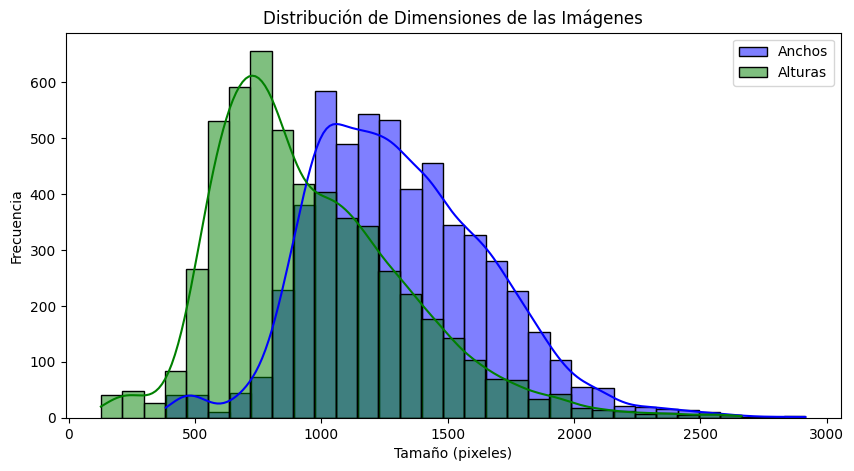

In [ ]:
# 3. Visualización de dimensiones de las imágenes en el set de entrenamiento
def plot_image_dimensions(df):
    dimensions = df.rdd.map(lambda row: Image.open(io.BytesIO(row.content)).size).collect()
    widths, heights = zip(*dimensions)
    plt.figure(figsize=(10, 5))
    sns.histplot(widths, color="blue", label="Anchos", kde=True, bins=30)
    sns.histplot(heights, color="green", label="Alturas", kde=True, bins=30)
    plt.title("Distribución de Dimensiones de las Imágenes")
    plt.xlabel("Tamaño (pixeles)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

plot_image_dimensions(train_df)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import IntegerType

# UDF to convert array of floats into DenseVector
def array_to_vector(arr):
    return Vectors.dense(arr)

# Register the UDF with correct return type
array_to_vector_udf = udf(array_to_vector, VectorUDT())

# Convert features column to DenseVector
train_df = train_df.withColumn("features_vector", array_to_vector_udf(train_df["features"]))
test_df = test_df.withColumn("features_vector", array_to_vector_udf(test_df["features"]))

# Verify consistency of feature dimensions for both train and test dataframes
train_df = train_df.withColumn("vector_size", udf(lambda x: len(x), IntegerType())(train_df["features"]))
test_df = test_df.withColumn("vector_size", udf(lambda x: len(x), IntegerType())(test_df["features"]))

# Check unique vector sizes in training data
vector_sizes = train_df.select("vector_size").distinct().collect()
print("Unique vector sizes in training data:", [row['vector_size'] for row in vector_sizes])

# Filter to ensure consistent feature vector length, assuming 150*150=22500 for grayscale or 150*150*3=67500 for RGB
expected_size = 22500  # Adjust to 67500 if images are RGB

train_df = train_df.filter(train_df["vector_size"] == expected_size)
test_df = test_df.filter(test_df["vector_size"] == expected_size)





Unique vector sizes in training data: [22500, 67500]


In [ ]:
# Initialize Linear Regression with specified parameters
lr = LinearRegression(featuresCol="features_vector", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_df)

# Print the coefficients and intercept
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

In [ ]:
# Make predictions on the test data
predictions = lrModel.transform(test_df)

In [ ]:
# Evaluate the model (note: LinearRegression is typically evaluated with RegressionEvaluator, not BinaryClassificationEvaluator)
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Test RMSE: {rmse}")

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)